Dieses Notebook ist angelehnt an das Buch *Python Data Science Handbook* von Jake VanderPlas, auch verfügbar auf [GitHubPages](https://jakevdp.github.io/PythonDataScienceHandbook/).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
from IPython.core.pylabtools import figsize
figsize(8, 6)

#### Hilfsfunktionen

In [3]:
# Convenience functions for visualizing concepts

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

# k-Means Clustering und Gaussian Mixture Models
[Video](https://mstream.hm.edu/paella/ui/watch.html?id=7b1f6255-9f2f-4930-9f38-a1f5a07f8869)

In diesem Kapitel betrachten wir wieder unsupervised Modelle, diesmal zum Clustern von Daten.

**Ziel:** Teile vorgegebene Daten auf in einzelne Gruppen ("Cluster").

**Links:**

*   [Grafischer Vergleich einiger Clusteringverfahren](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)
*   [scikit-learn algorithm cheat-sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)



## k-Means
Die Grundidee von k-Means hatten wir schon besprochen, sie ist in der Tat recht einfach: Die Punkte einer gegebenen Datenmenge sollen optimal in eine *vom Benutzer festgelegte* Anzahl von Clustern unterteilt werden. Optimal bedeutet dabei:
- Das "Zentrum eines Clusters" ist der arithmetische Mittelwert aller Punkte, die zu diesem Cluster gehören.
- Jeder Punkt liegt näher am Zentrum seines eigenen Clusters als an jedem anderen Cluster-Zentrum.

Wir betrachten folgende Beispieldaten:

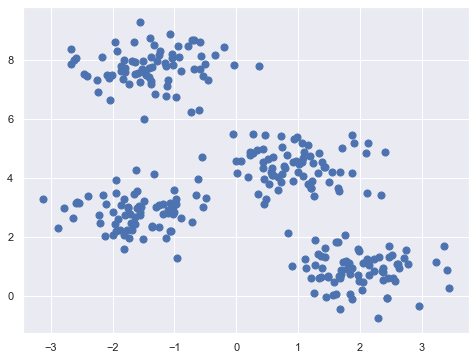

In [4]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Bei diesen Daten ist es recht einfach, eine intuitive Aufteilung in vier Cluster anzugeben.

Wir verwenden nun *k-Means* um das durchzuführen:

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Die Ergebnisse stellen wir nun grafisch dar (Colorcoding) und auch die Cluster-Zentren zeichnen wir ein:

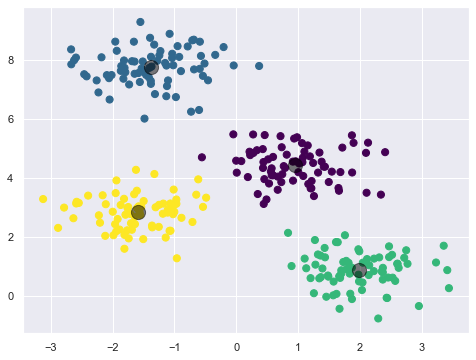

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Wie kann das so schnell gehen? Sicherlich nicht durch ausprobieren aller Optionen!

## Funktionsweise von k-Means: Expectation-Maximization
Expectation-Maximization (E-M) ist eine mächtige (da vielseitig einsetzbare) Heuristik, die insbes. bei k-Means zum Einsatz kommt. Sie funktioniert im vorliegenden Fall folgendermaßen:
1. Rate Cluster-Zentren
2. Wiederhole folgende Schirtte solange bis Konvergenz erreicht ist:
    1. *E-Schritt*: Ordne jedem Punkt dem Cluster zu, dessen Zentrum ihm am nächsten liegt
    2. *M-Schritt*: Update der Cluster-Zentren: Setze jedes Cluster-Zentrum auf den Mittelwert des jeweiligen Clusters

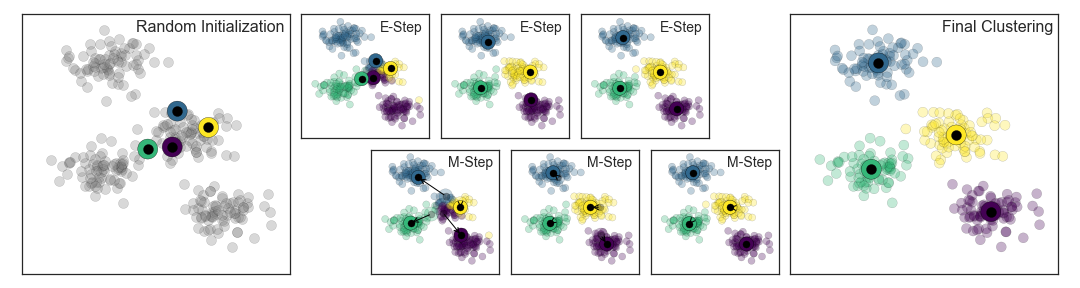

Das kann aber auch schief gehen:
## Nachteile von E-M

### Global optimale Lösung wird nicht garantiert gefunden
Der E-M Algorithmus verbessert zwar garantiert die Lösung in jedem Schritt, das bedeutet aber nicht, dass die global beste Lösung gefunden wird. Um das zu verdeutlichen verwenden wir eine andere Startkonfiguration der Cluster-Zentren:

In [12]:
[pt[0] for pt in [[-2,8],[0,4],[3,0],[2,1]]]

[-2, 0, 3, 2]

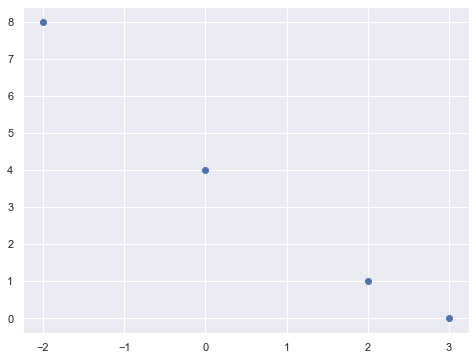

In [16]:
plt.scatter([pt[0] for pt in [[-2,8],[0,4],[3,0],[2,1]]], [pt[1] for pt in [[-2,8],[0,4],[3,0],[2,1]]])

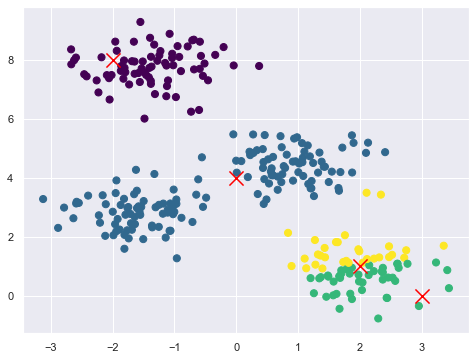

In [24]:
pt_init = [[-2,8],[0,4],[3,0],[2,1]]
labels = KMeans(4, n_init=1, init=np.asarray(pt_init)).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.scatter([pt[0] for pt in pt_init], [pt[1] for pt in pt_init], s=200, c='red', marker='x');

Das liegt an der hier sehr ungünstigen Wahl an initialen Cluster-Zentren. Die ``sklearn`` Implementierung von k-Means verwendet eine geschicktere Initialisierung und führt auch mehrere Clusterungen durch. Deren Anzahl wird durch den Hyperparameter ``n_init`` angegeben, der per Default den Wert 10 hat. Aus den ``n_init`` erzeugten Clusterungen wird dann die beste ausgewählt und verwendet.

### Anzahl der Cluster muss vor dem Clustering definiert werden
Ist die Anzahl "falsch" gewählt, erhält man fragwürdige Ergebnisse. Um die "richtige" Anzahl an Clustern zu erhalten, kann man z.B. die sog. [Silhouette Analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) verwenden.

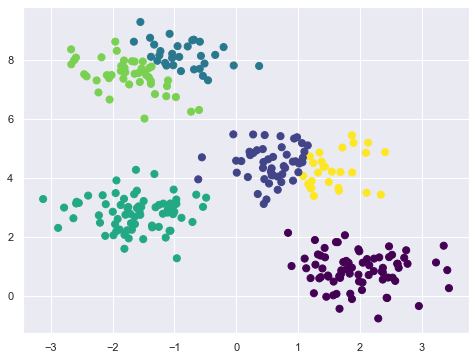

In [25]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Alternativ können auch Verfahren verwendet werden, die selbstständig eine passende Anzahl an Clustern bestimmen können, z.B. DBSCAN, Mean-Shift, oder Affinity Propagation (alle verfügbar in ``sklearn.cluster``).

### Einschränkung auf lineare Cluster-Grenzen
Ein Punkt wird immer dem Cluster zugeordnet, zu dessen Zentrum er den kleinsten Abstand hat. Das führt bei komplizierteren Geometrien zu Problemen:

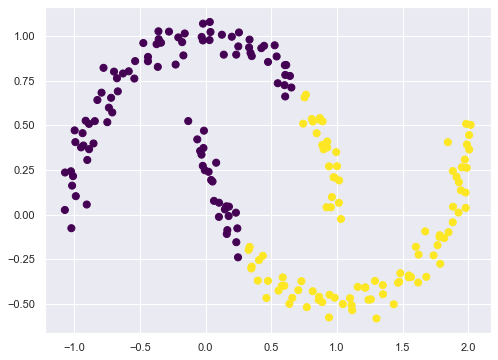

In [26]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Dieses Problem erinnert an die Situation bei SVM. Dort hatten wir zur Lösung des Problems den Kernel-Trick verwendet. Auch für k-Means gibt es eine "Kernel-Version", diese ist in ``sklearn`` verfügbar als ``SpectralClustering``:

c:\Users\Cris\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


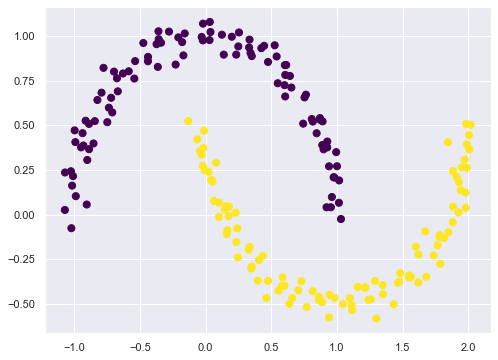

In [27]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Motivation von GMM
Wir fokussieren uns auf zwei wesentliche Nachteile von k-Means:
- Cluster sind (bezogen auf die Trainingsdaten) immer kreisförmig
- Es gibt kein Maß der Zuversicht, ob ein Punkt korrekt eingeordnet wurde

Wir können uns ein k-Means Modell so vorstellen, dass das Zentrum eines Clusters den Mittelpunkt eines Kreises (in 2d, ansonsten höherdimensionale Bälle) darstellt, dessen Radius die Entfernung vom Mittelpunkt zu dem am weitesten entfernten Punkt des Clusters ist. Alle Punkte innerhalb dieses Kreises gehören zu diesem Cluster, alle Punkte außerhalb nicht.

In [28]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

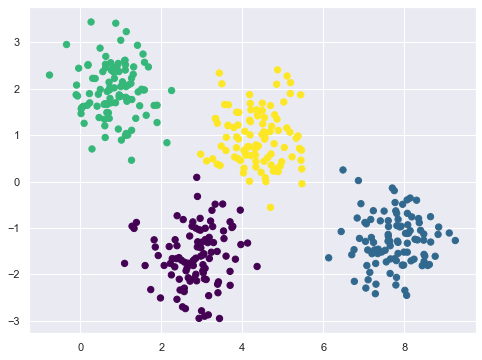

In [29]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

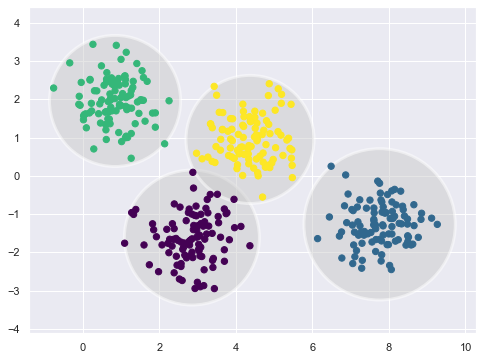

In [30]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Diese "Entscheidungsformen" müssen Kreise sein - ob das passt oder nicht...

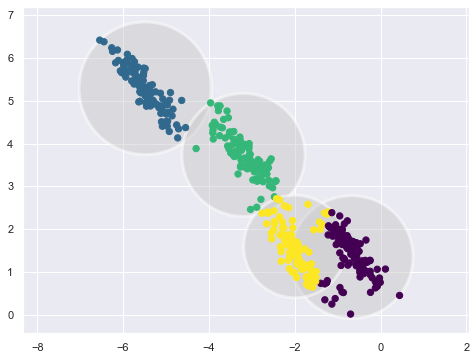

In [31]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

Hier würden wir intuitiv viel eher Ellipsen verwenden.

## Gaussian Mixture Models
Ein Gaussian Mixture Model (GMM) macht genau das möglich: Als Cluster-Grenzen dienen allgemeine Ellipsen.
Auch der zweite o.g. Punkt wird adressiert: Die "Zuversicht" des Modells, ob ein Punkt zu einem Cluster gehört, wird dadurch quantifiziert, dass die Abstände zu *allen* Clustern betrachtet werden.

Ein GMM sucht nach einer Mischung von (mehrdimensionalen) Gaussverteilungen, die die vorliegenden Daten bestmöglich modellieren. Sie können insbesondere zur Clusterung verwendet werden:

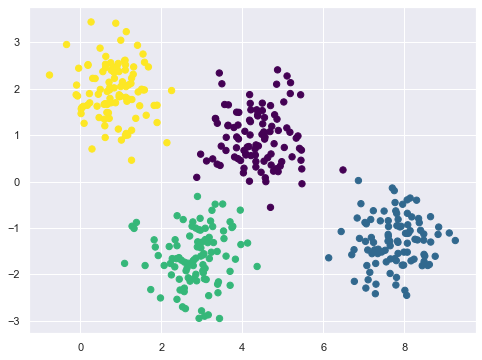

In [32]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Weil hier intern ein probabilistisches Modell verwendet wird, steht wieder die Methode ``predict_proba`` zur Verfügung. Hier die Wahrscheinlichkeiten der Clusterzugehörigkeit der ersten fünf Punkte:

In [33]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.469 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


Die dadurch vorhandene Information über die Unsicherheit können wir z.B. visualisieren, indem wir die Punkte entsprechend skalieren:
- Punkte, bei denen sich das Modell sicher ist, erscheinen groß.
- Punkte, bei denen sich das Modell unsicher ist, erscheinen klein.

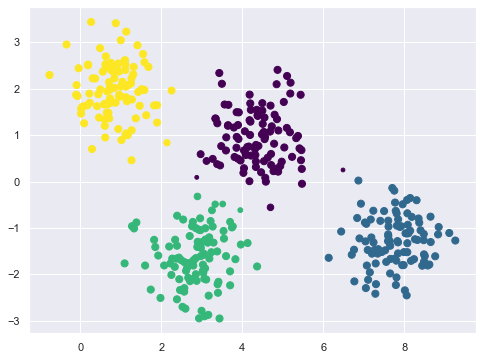

In [34]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

GMM verwendet ebenfalls den Expectation-Maximization Ansatz:
1. Rate die Position und Form der Ausgangscluster
2. Wiederhole folgende Schirtte solange bis Konvergenz erreicht ist:
    1. *E-Schritt*: Ordne jedem Punkt Gewichte zu, die die Wahrscheinlichkeit angeben, dass der Punkt zu jedem einzlen Cluster gehört.
    2. *M-Schritt*: Update der Cluster: Wähle die Position, Normalisierung und Form eines jeden Clusters so, dass es bestmöglich zu *allen* Datenpunkten passt (unter Verwendung der Gewichte).
    
Dadurch erhalten die Cluster keine harte Grenze, sondern einen weichen "Gauss-artigen" Verlauf.
Angewendet auf die ursprünglichen Punkte:

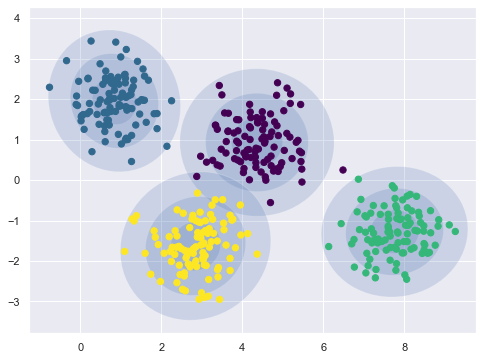

In [35]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Angewendet auf die verzerrten Punkte:

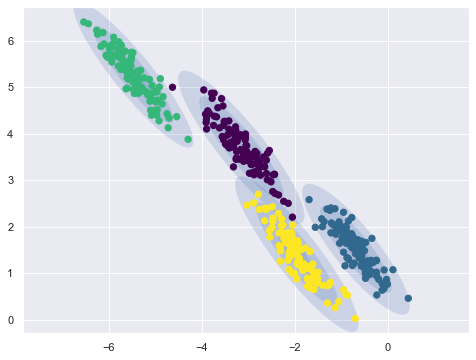

In [36]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Der Wesentlicher Hyperparameter ist ``covariance_type``. Ist dieser auf ``diag`` gesetzt, so werden dem Modell nur Ellipsen erlaubt, deren Hauptachsen parallel zu den Koordinatenachsen sind. Dieser Typ ist am wenigsten rechenintensiv. ``covriance_type='full'`` erlaubt hingegen beliebige Ellipsen, benötigt aber wesentlich mehr Rechenzeit.


## GMM als Dichte-Schätzer (Density Estimation)
Wir haben GMM hier als Clustering-Verfahren eingeführt. Vom theoretischen Hintergrund her gesehen, ist es aber ein generatives Modell, d.h. es erzeugt eine Wahrscheinlichkeitsverteilung (genauer: Dichte-Funktion), die zu den Daten passt.

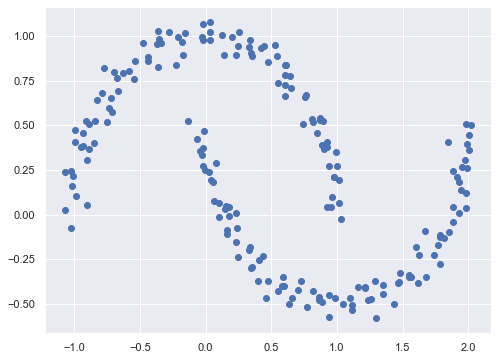

In [37]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Um diese Daten mit GMM zu clustern, würde man ein GMM mit zwei Komponenten verwenden. Das ist hier aber nicht sonderlich sinnvoll:

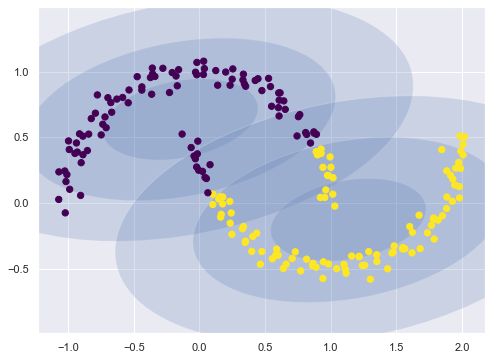

In [38]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Wenn wir nun aber den Clusterungsgedanken beiseite schieben, können wir ein GMM mit deutlich mehr Komponenten verwenden, welches die *Verteilung* der Daten approximieren wird.

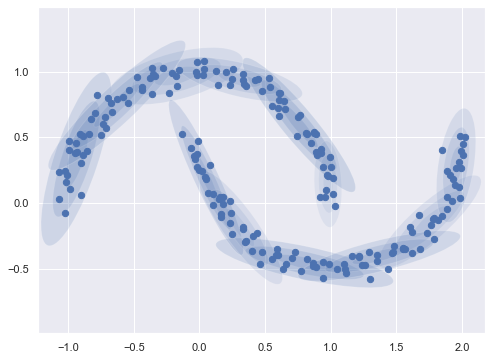

In [39]:
gmm16 = GaussianMixture(n_components=12, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Damit haben wir ein generatives Modell (bestehend aus 16 Gaussverteilungen) erstellt, welches die Daten recht gut beschreibt. Dieses Modell erlaubt es uns, *neue Daten zu generieren*, die ähnlich zu den Originaldaten verteilt sind. Wir erzeugen *mit diesem Modell* nun 400 weitere Punkte:

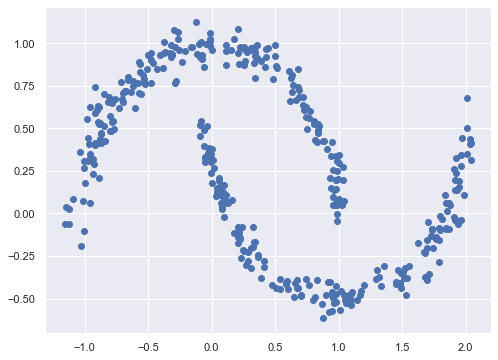

In [40]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

Die wesentlich Frage ist nun, aus wie vielen Komponenten das Modell bestehen sollte? Ein generatives Modell gibt uns eine Wahrscheinlichkeitsverteilung an und damit können wir prüfen, wie wahrscheinlich es (unter unserem Modell) ist, dass die vorliegenden Daten erzeugt werden. Hier sollte Cross-Validation verwendet werden, um Overfitting zu vermeiden.

Overfitting kann auch mit theoretischen Ansätzen vermieden werden. Dafür sind in ``GaussianMixtureModel`` direkt zwei nützliche Kriterien eingebaut: AIC (Akaike Information Criterion) und BIC (Bayesian Information Criterion). Diese beiden Kenngrößen betrachten wir nun für unsere Beispieldaten in Abhängigkeit von der Anzahl der verwendeten Komponenten:

c:\Users\Cris\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


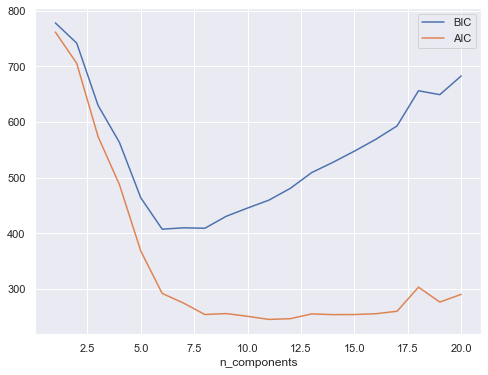

In [41]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Die optimale Anzahl an Komponenten ist diejenige, die AIC oder BIC minimiert. Die verwendeten 16 Komponenten waren wohl etwas zu viel, 8-12 wäre passender gewesen.
**Das gibt uns nur eine Aussage darüber, wie viele Komponenten wir für das generative Modell wählen sollten. Es gibt keine Aussage über die Anzahl der sinnvollen Cluster.**

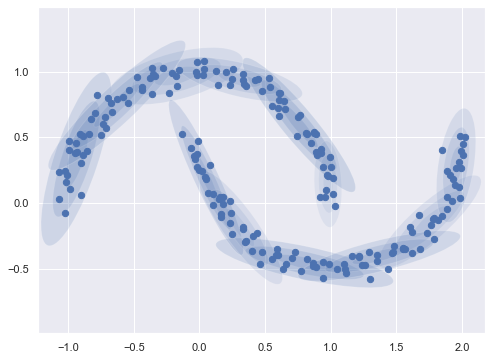

In [42]:
gmm12 = GaussianMixture(n_components=12, covariance_type='full', random_state=0)
plot_gmm(gmm12, Xmoon, label=False)

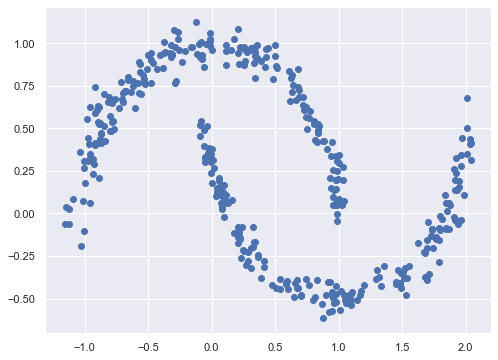

In [43]:
Xnew = gmm12.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

## Beispiel: GMM zur Erzeugung neuer Daten
Wir wollen diese generative Eigentschaft von GMM nun am Beispiel handschriftlicher Zahlen verdeutlichen.

Wir laden die Daten...

In [44]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

... und plotten die ersten 100 Ziffern:

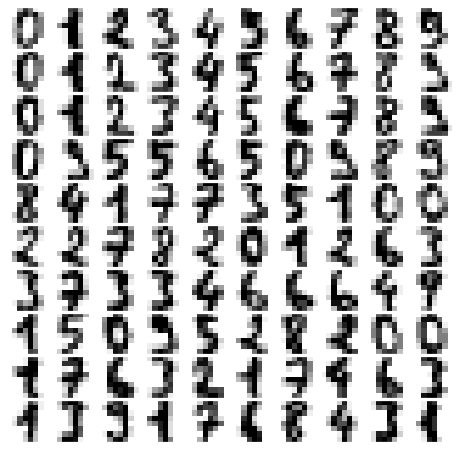

In [45]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Wir haben also 1797 Datenpunkte in einem 64 dimensionalen Raum. Unser Ziel ist es nun, die Wahrscheinlichkeitsverteilung zu lernen (oder anzunähern), die diese Punkte generiert hat. Damit können wir dann *neue* solche Punkte erzeugen. Im vorliegenden Anwendungsfall wären das handgeschriebene Ziffern.

Da GMMs in höheren Dimensionen häufig mit Konvergenzproblemen zu kämpfen haben, verwenden wir als erstes eine moderate Dimensionsreduktion: PCA, so dass 99% der Varianz erhalten bleibt:

In [46]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

Wir haben nun nur noch 41-dimensionale Daten, d.h. ca. 35% weniger, haben aber weniger als 1% der Information eingebüßt :-)

Nun verwenden wir das AIC, um eine geeigente Anzahl von Komponenten für unser GMM zu bestimmen:

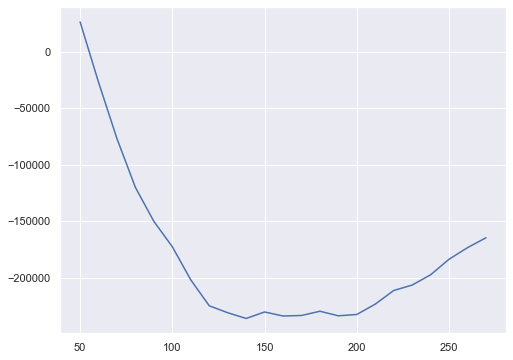

In [47]:
n_components = np.arange(50, 280, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

Wir verwenden 140 Komponenten und prüfen, ob das Training konvergiert ist:

In [48]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Nun nutzen wir dieses trainierte GMM um 100 *neue* Punkte in dem 41-dimensionalen Raum zu generieren:

In [49]:
data_new = gmm.sample(100)
data_new[0].shape

(100, 41)

Auf diese wenden wir nun die inverse PCA an (diese macht aus den 41d Punkten wieder 64d Punkte), welche wir dann wie gewohnt visualisieren können:

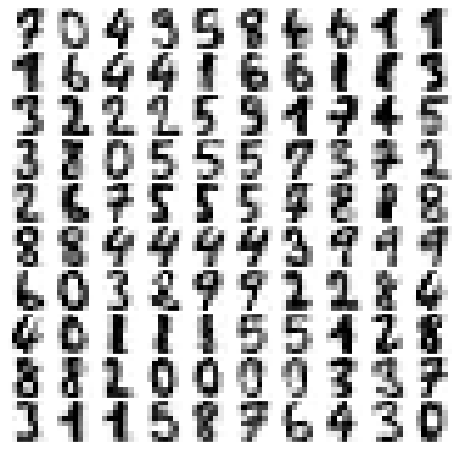

In [50]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)

Das sind nun neue, vom Modell generierte Ziffern!